# Tour of hera_sim

This notebook briefly introduces some of the effects that can be modeled with `hera_sim`.

In [7]:
%matplotlib inline
import aipy
import uvtools
import numpy as np
import pylab as plt
from hera_sim import DATA_PATH
plt.rcParams["figure.figsize"] = [14, 8]

In [9]:
from hera_sim import foregrounds, noise, sigchain, rfi
from hera_sim.interpolators import Beam, Bandpass

In [10]:
h1c_beam = Beam(datafile=DATA_PATH / "HERA_H1C_BEAM_POLY.npy")

In [4]:
fqs = np.linspace(0.1, 0.2, 1024, endpoint=False)
lsts = np.linspace(0, 2 * np.pi, 10000, endpoint=False)
times = lsts / (2 * np.pi) * aipy.const.sidereal_day
bl_len_ns = np.array([30.0, 0, 0])

## Foregrounds

### Diffuse Foregrounds

In [11]:
Tsky_mdl = noise.HERA_Tsky_mdl["xx"]
vis_fg_diffuse = foregrounds.diffuse_foreground(
    lsts, fqs, bl_len_ns, Tsky_mdl=Tsky_mdl, omega_p=h1c_beam
)

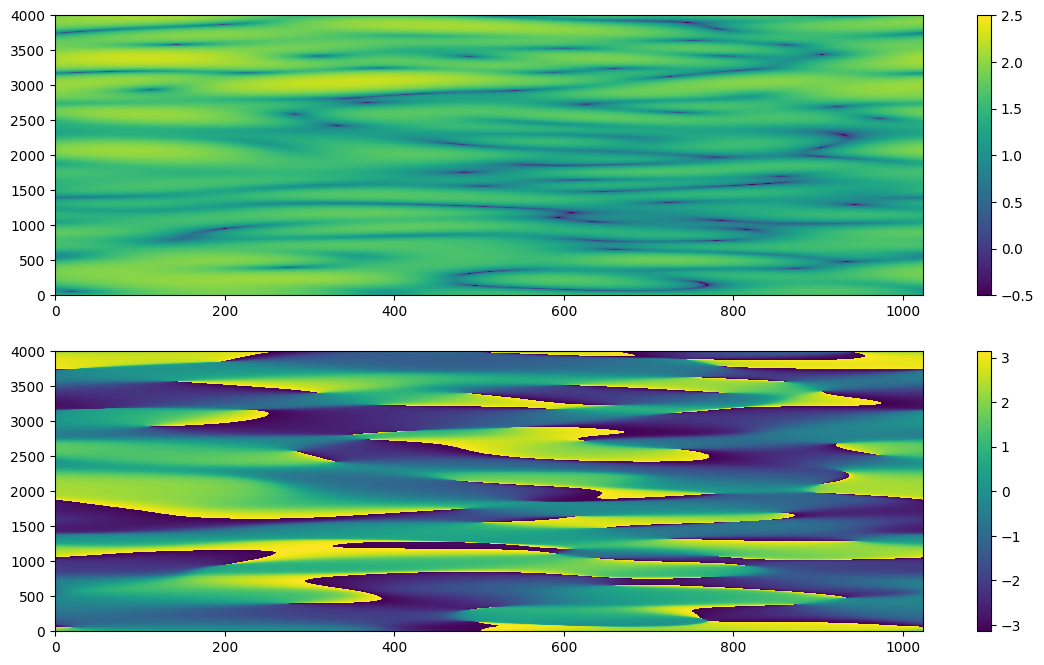

In [12]:
MX, DRNG = 2.5, 3
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_fg_diffuse, mode="log", mx=MX, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_fg_diffuse, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

### Point-Source Foregrounds

In [13]:
vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

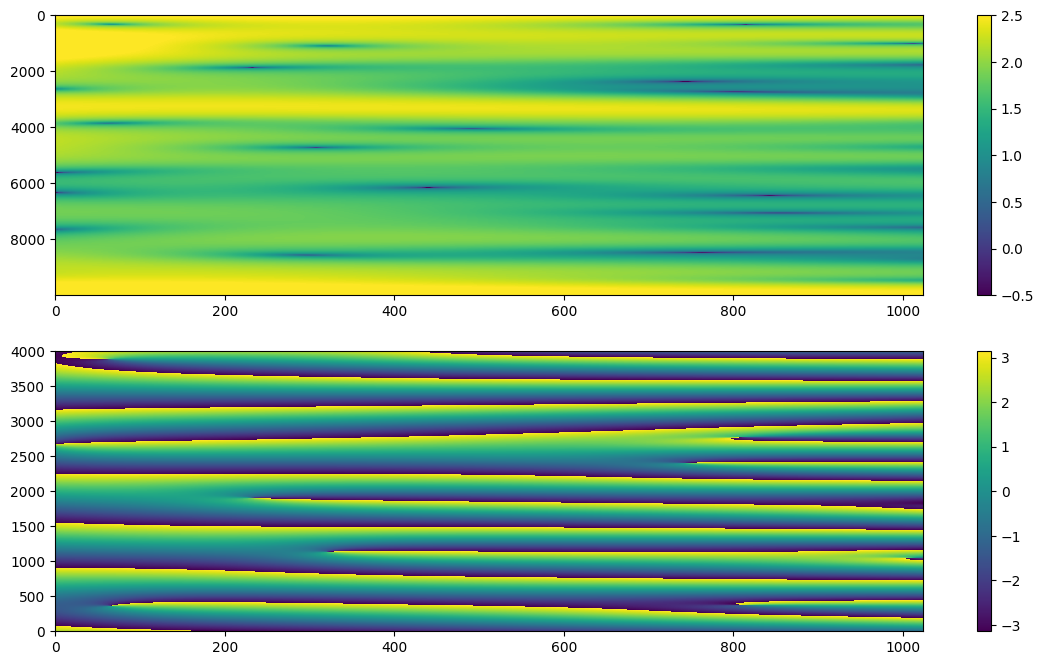

In [14]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_fg_pntsrc, mode="log", mx=MX, drng=DRNG)
plt.colorbar()  # ; plt.ylim(0,4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_fg_pntsrc, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

### Diffuse and Point-Source Foregrounds

In [15]:
vis_fg = vis_fg_diffuse + vis_fg_pntsrc

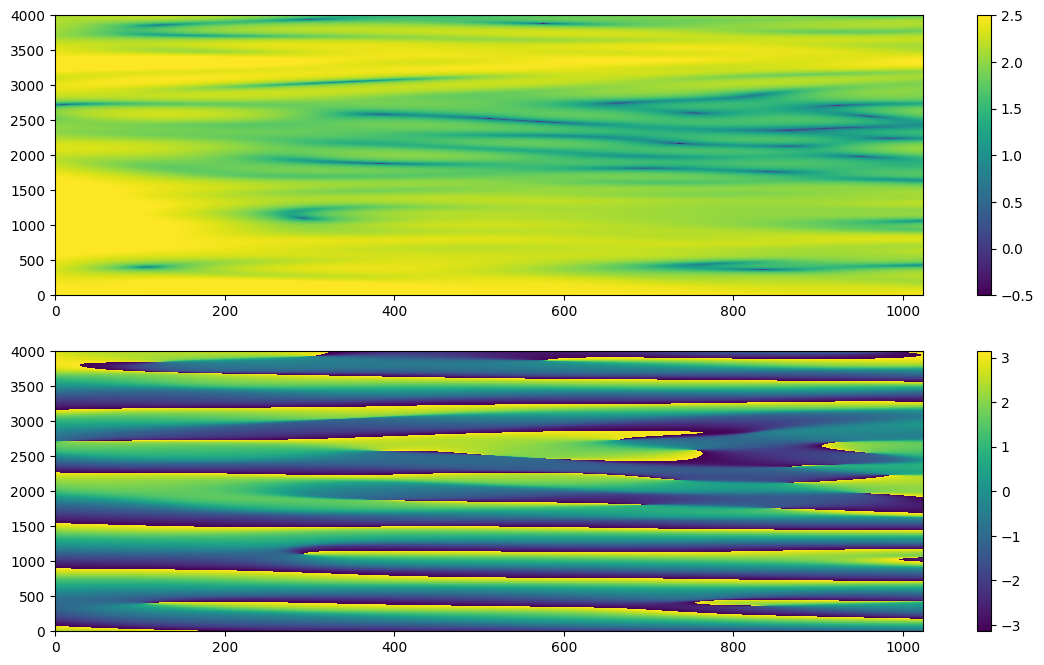

In [16]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_fg, mode="log", mx=MX, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_fg, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

## Noise

In [17]:
tsky = noise.resample_Tsky(fqs, lsts, Tsky_mdl=noise.HERA_Tsky_mdl["xx"])
t_rx = 150.0
omega_p = bm_poly_to_omega_p(fqs)
nos_jy = noise.sky_noise_jy(lsts, fqs, omega_p=omega_p)

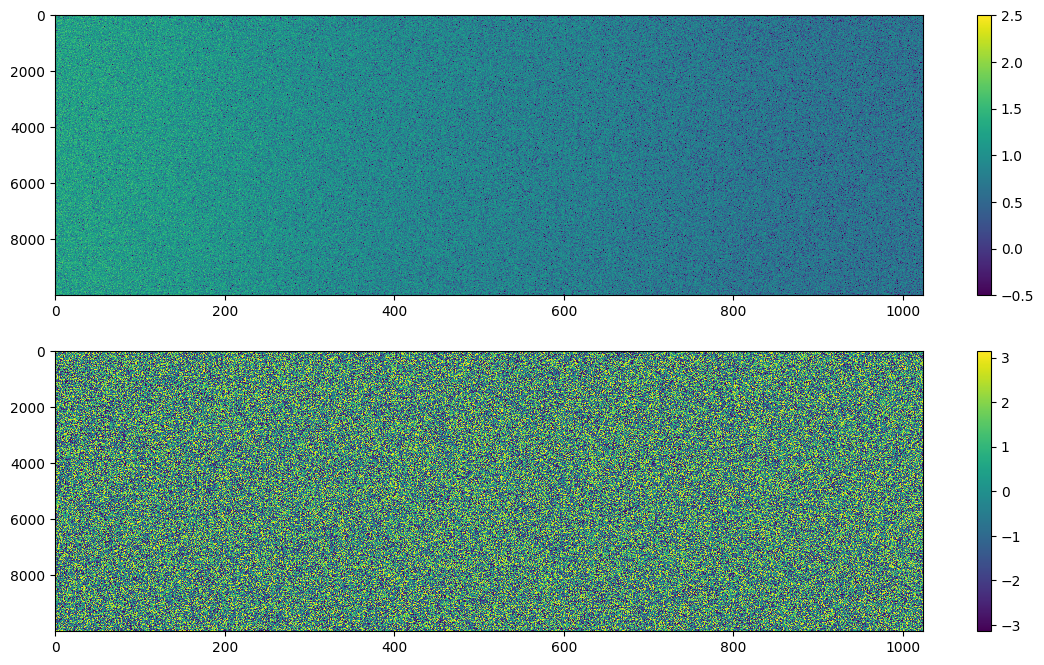

In [18]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(nos_jy, mode="log", mx=MX, drng=DRNG)
plt.colorbar()  # ; plt.ylim(0,4000)
plt.subplot(212)
uvtools.plot.waterfall(nos_jy, mode="phs")
plt.colorbar()  # ; plt.ylim(0,4000)
plt.show()

In [19]:
vis_fg_nos = vis_fg + nos_jy

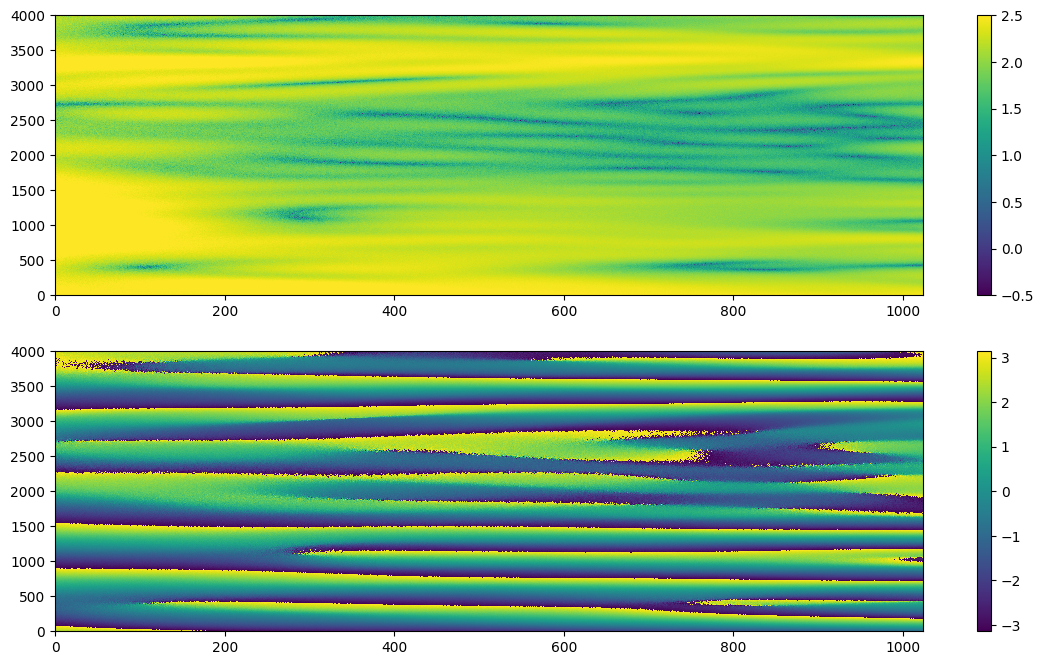

In [20]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_fg_nos, mode="log", mx=MX, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_fg_nos, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

## RFI

In [25]:
lsts.shape

(10000,)

In [26]:
rfi1 = rfi.rfi_stations(lsts, fqs)
rfi2 = rfi.rfi_impulse(lsts, fqs, impulse_chance=0.02)
rfi3 = rfi.rfi_scatter(lsts, fqs, scatter_chance=0.001)
rfi_all = rfi1 + rfi2 + rfi3

You did not specify any stations to simulate.


divide by zero encountered in log10


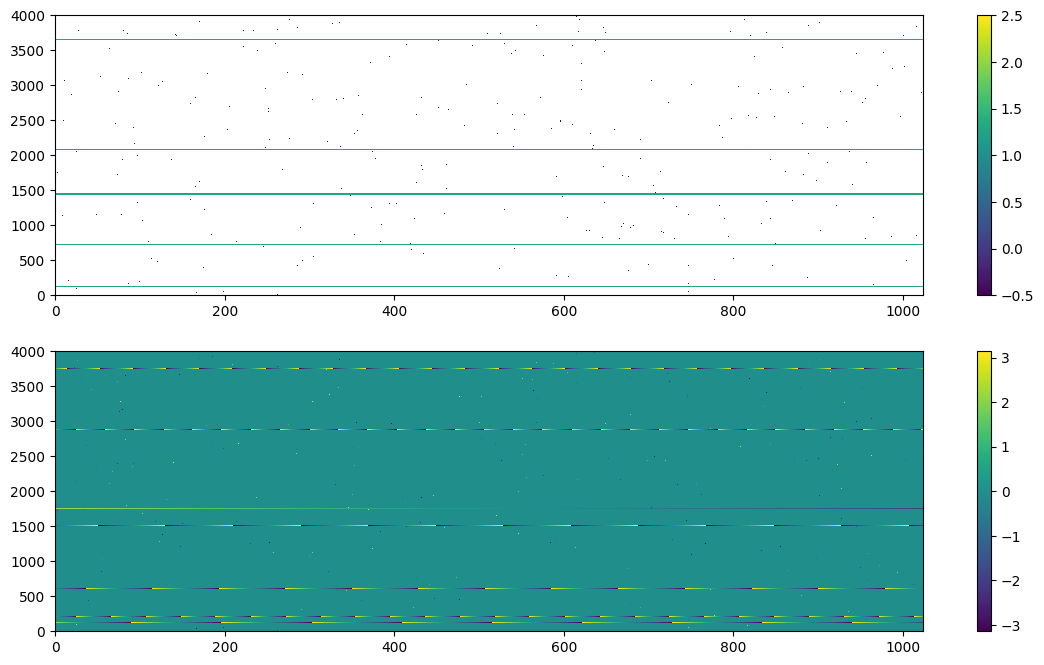

In [27]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(rfi_all, mode="log", mx=MX, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(rfi_all, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

In [28]:
vis_fg_nos_rfi = vis_fg_nos + rfi_all

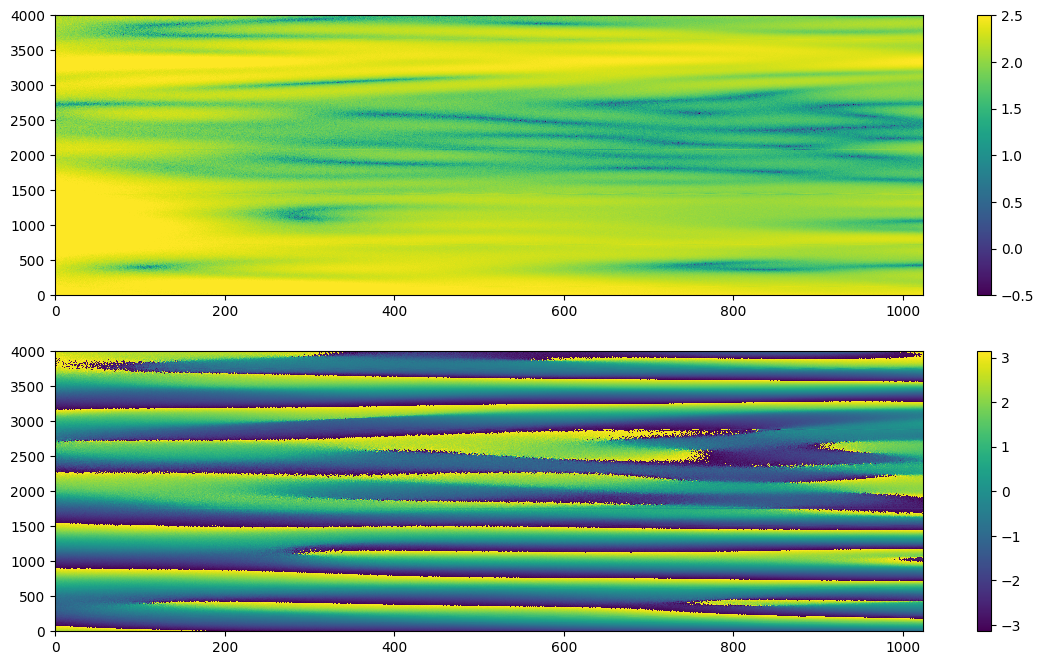

In [29]:
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_fg_nos_rfi, mode="log", mx=MX, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_fg_nos_rfi, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

## Gains

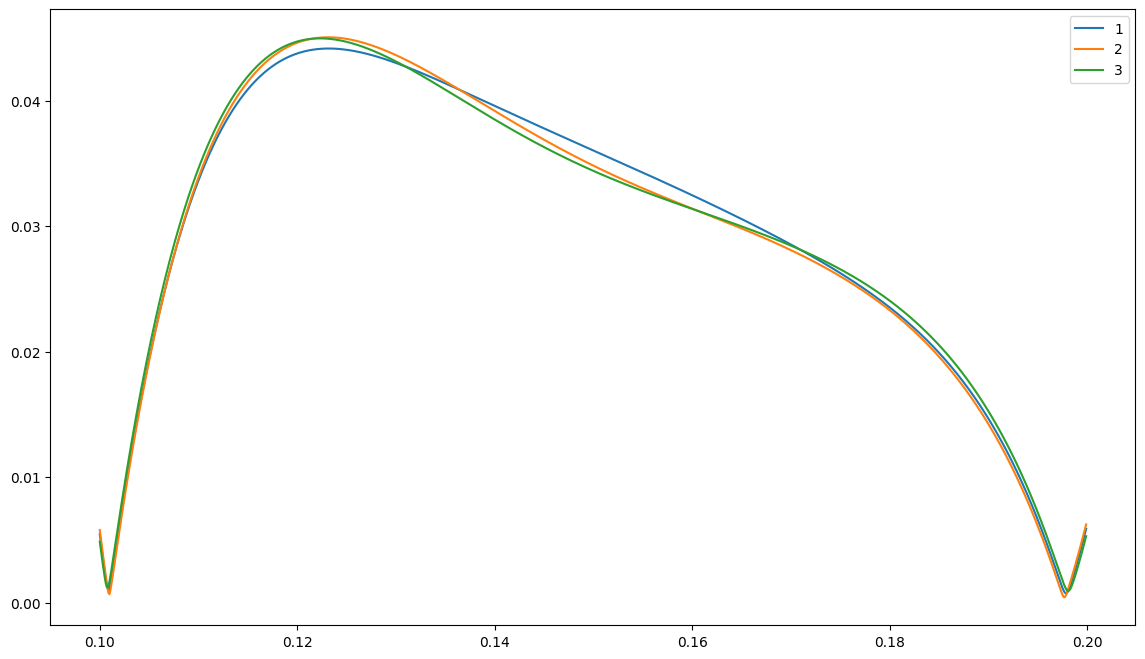

In [30]:
g = sigchain.gen_gains(fqs, [1, 2, 3])
plt.figure()
for i in g:
    plt.plot(fqs, np.abs(g[i]), label=str(i))
plt.legend()
plt.show()
gainscale = np.average([np.median(np.abs(g[i])) for i in g])
MXG = MX + np.log10(gainscale)

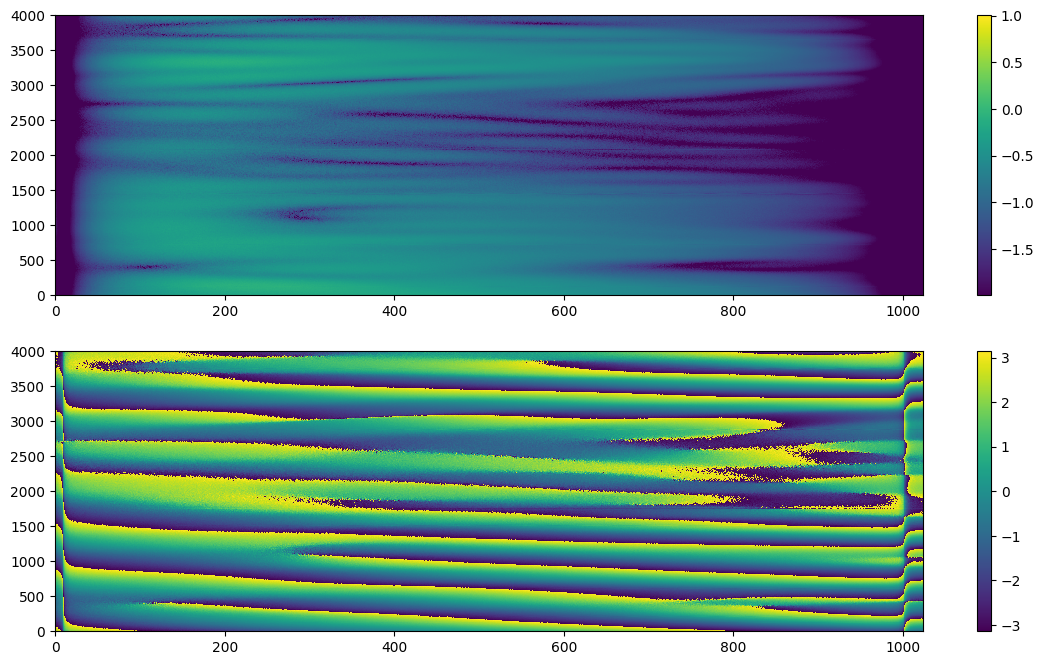

In [31]:
vis_total = sigchain.apply_gains(vis_fg_nos_rfi, g, (1, 2))
plt.figure()
plt.subplot(211)
uvtools.plot.waterfall(vis_total, mode="log", mx=MXG, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_total, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)
plt.show()

## Crosstalk

(0.0, 4000.0)

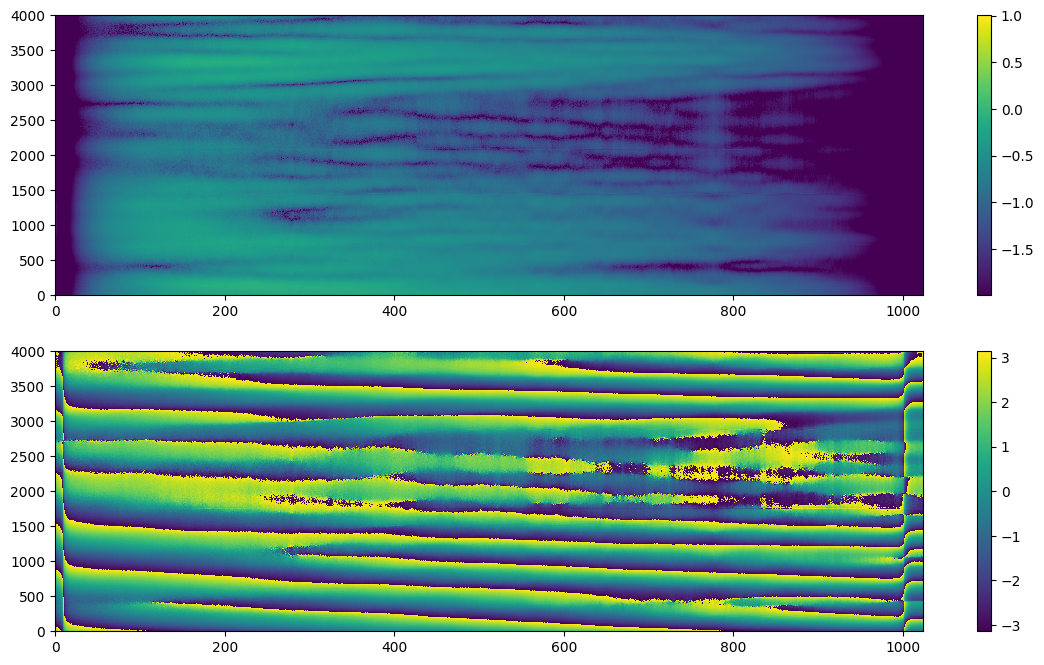

In [32]:
xtalk = sigchain.gen_whitenoise_xtalk(fqs)
if xtalk.ndim == 1:
    xtalk = np.reshape(xtalk, (1, -1))
vis_xtalk = vis_fg_nos_rfi + xtalk
vis_xtalk = sigchain.apply_gains(vis_xtalk, g, (1, 2))

plt.subplot(211)
uvtools.plot.waterfall(vis_xtalk, mode="log", mx=MXG, drng=DRNG)
plt.colorbar()
plt.ylim(0, 4000)
plt.subplot(212)
uvtools.plot.waterfall(vis_xtalk, mode="phs")
plt.colorbar()
plt.ylim(0, 4000)